In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib.pyplot as plt
#%pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/experience_MNIST_CNN')


In [11]:
# ============================================
# 1. CONFIGURATION
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cpu


In [12]:
# ============================================
# 2. CHARGEMENT DES DONNÉES
# ============================================
transform = Compose([
    Resize((32, 32)),
    ToTensor(),
])

donnees_entrainement = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
donnees_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

dataloader_entrainement = DataLoader(
    donnees_entrainement,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)
dataloader_test = DataLoader(
    donnees_test,
    batch_size=64,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

print(f"Classes : {donnees_entrainement.classes}")
print(f"Images d'entraînement : {len(donnees_entrainement)}")
print(f"Images de test : {len(donnees_test)}")

Classes : ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Images d'entraînement : 60000
Images de test : 10000


In [13]:
# ============================================
# 3. DÉFINITION DU MODÈLE CNN AVEC DROPOUT
# ============================================
class ModeleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Couches convolutives
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Couches de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Couches fully connected
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # Dropout après la première couche fully connected
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Appliquer les couches convolutives et de pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Aplatir pour les couches fully connected
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # Appliquer le Dropout
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instancier le modèle
modele = ModeleCNN().to(device)
print(modele)

# Tester la forme de sortie
X_test = torch.rand(1, 1, 32, 32, device=device)
logits = modele(X_test)
print(f"Forme de sortie : {logits.shape}")

ModeleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Forme de sortie : torch.Size([1, 10])


In [14]:
# ============================================
# 4. LOSS ET OPTIMISEUR
# ============================================
fonction_perte = nn.CrossEntropyLoss()
optimiseur = optim.Adam(modele.parameters(), lr=1e-3)

In [15]:
# ============================================
# 5. FONCTIONS D'ENTRAÎNEMENT ET TEST
# ============================================
def entrainer(dataloader, modele, fonction_perte, optimiseur, epoch):
    taille = len(dataloader.dataset)
    modele.train()
    perte_cumul = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = modele(X)
        perte = fonction_perte(pred, y)

        optimiseur.zero_grad()
        perte.backward()
        optimiseur.step()

        perte_cumul += perte.item()
        if batch_idx % 100 == 0:
            valeur_perte, actuel = perte.item(), (batch_idx + 1) * len(X)
            print(f"perte : {valeur_perte:>7f} [{actuel:>5}/{taille:>5}]")

    # Log la perte moyenne pour l'époque
    writer.add_scalar('Perte/entrainement', perte_cumul / len(dataloader), epoch)

def tester(dataloader, modele, fonction_perte, epoch):
    taille = len(dataloader.dataset)
    num_batches = len(dataloader)
    modele.eval()
    perte_test, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = modele(X)
            perte_test += fonction_perte(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    perte_test /= num_batches
    precision = correct / taille
    print(f"Erreur de test : \n Précision : {(100*precision):>0.1f}%, Perte moyenne : {perte_test:>8f} \n")

    # Log la perte et la précision pour le test
    writer.add_scalar('Perte/test', perte_test, epoch)
    writer.add_scalar('Précision/test', precision, epoch)

    return precision

c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


perte : 2.305027 [   64/60000]
perte : 0.468478 [ 6464/60000]
perte : 0.392114 [12864/60000]
perte : 0.417597 [19264/60000]
perte : 0.191891 [25664/60000]
perte : 0.097592 [32064/60000]
perte : 0.180775 [38464/60000]
perte : 0.163001 [44864/60000]
perte : 0.182325 [51264/60000]
perte : 0.116284 [57664/60000]
Erreur de test : 
 Précision : 98.2%, Perte moyenne : 0.054211 

✓ Nouveau meilleur modèle sauvegardé ! Précision : 98.2%
perte : 0.171536 [   64/60000]
perte : 0.056697 [ 6464/60000]
perte : 0.118672 [12864/60000]
perte : 0.041460 [19264/60000]
perte : 0.100971 [25664/60000]
perte : 0.017404 [32064/60000]
perte : 0.087943 [38464/60000]
perte : 0.068313 [44864/60000]
perte : 0.030342 [51264/60000]
perte : 0.177373 [57664/60000]
Erreur de test : 
 Précision : 98.5%, Perte moyenne : 0.042793 

✓ Nouveau meilleur modèle sauvegardé ! Précision : 98.5%
perte : 0.014056 [   64/60000]
perte : 0.140958 [ 6464/60000]
perte : 0.019605 [12864/60000]
perte : 0.042447 [19264/60000]
perte : 0.17

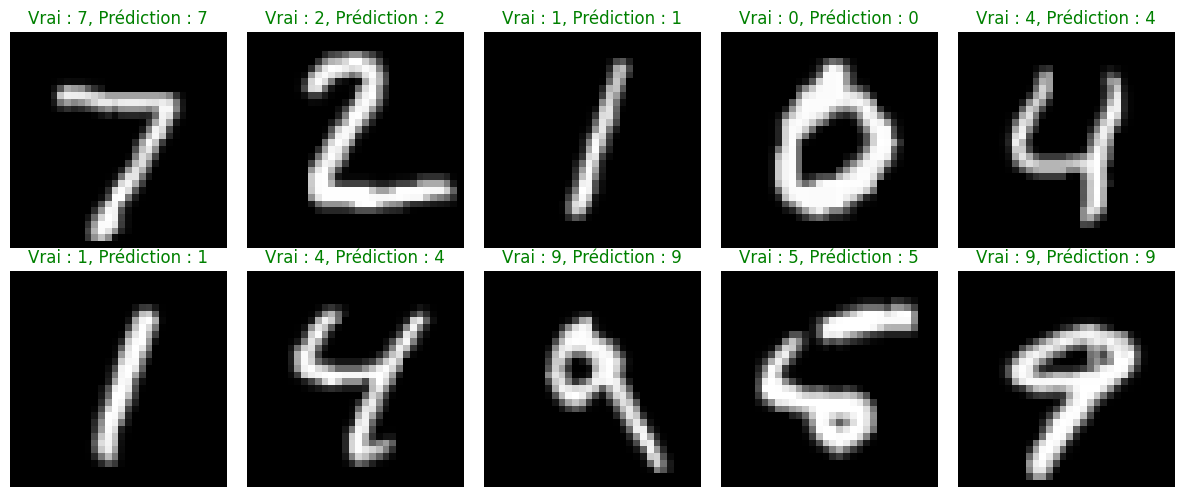

In [ ]:
# ============================================
# 6. ENTRAÎNEMENT  AVEC TENSERBOARD
# ============================================
epochs = 10
meilleure_precision = 0.0

for t in range(epochs):
    print(f"Époque {t+1}/{epochs}\n---------------------------------------")
    entrainer(dataloader_entrainement, modele, fonction_perte, optimiseur, t)
    precision = tester(dataloader_test, modele, fonction_perte, t)

    if precision > meilleure_precision:
        meilleure_precision = precision
        torch.save(modele.state_dict(), "meilleur_modele_cnn_dropout.pth")
        print(f"✓ Nouveau meilleur modèle sauvegardé ! Précision : {100*precision:.1f}%")

print("Terminé ! Entraînement complété.")
print(f"Meilleure précision : {100*meilleure_precision:.1f}%")

writer.close()

# ============================================
# 7. TESTER LE MODÈLE SUR QUELQUES EXEMPLES
# ============================================
modele.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        img, label = donnees_test[i]
        img_batch = img.unsqueeze(0).to(device)
        pred = modele(img_batch)
        pred_label = pred.argmax(1).item()

        ax.imshow(img.squeeze(), cmap='gray')
        couleur = 'green' if pred_label == label else 'red'
        ax.set_title(f"Vrai : {label}, Prédiction : {pred_label}", color=couleur)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# ============================================
# 8. EXPORT VERS ONNX
# ============================================
modele.eval()
exemple_entree = torch.randn(1, 1, 32, 32).to(device)
torch.onnx.export(
    modele,
    exemple_entree,
    "image_classifier_cnn_dropout.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['x'],
    output_names=['output'],
    dynamic_axes={
        'x': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)
print("✓ Modèle exporté vers image_classifier_cnn_dropout.onnx")

C:\Users\Talyha Moreau\AppData\Local\Temp\ipykernel_25604\1932681604.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1211 15:54:13.523000 25604 Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ModeleCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ModeleCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).
Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.
✓ Modèle exporté vers image_classifier_cnn_dropout.onnx


In [ ]:
import onnx

model = onnx.load("image_classifier_cnn_dropout.onnx")
onnx.save_model(model, "image_classifier_cnn_dropout_merged.onnx", save_as_external_data=False)

FileNotFoundError: [Errno 2] No such file or directory: 'image_classifier_cnn.onnx'